In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Chỉnh lại PM2.5/Bản sao của AirQualityHoChiMinhCity.csv')
df.head(5)

,date,Station_No,TSP,PM2.5,O3,CO,NO2,SO2,Temperature,Humidity
0,23-02-2021 21:00,1,32.935714,15.604762,55.431381,1330.451429,112.740762,393.000000,28.361905,63.188095
1,23-02-2021 22:00,1,30.932353,14.594118,58.197176,1200.603529,112.366471,377.588235,28.320588,63.773529
2,23-02-2021 23:00,1,27.645000,13.436667,55.029433,1177.897000,112.700433,372.476667,28.336667,64.205000
3,24-02-2021 00:00,1,24.380000,12.365000,54.767700,1267.476000,112.480867,389.070000,28.305000,64.735000
4,24-02-2021 01:00,1,22.521667,11.636667,53.786200,1322.293000,114.331500,393.000000,28.300000,65.188333


# Trực quan hoá data trước xử lý

In [ ]:
df.columns

Index(['date', 'Station_No', 'TSP', 'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
       'Temperature', 'Humidity'],
      dtype='object')

In [ ]:
print(df['Station_No'].value_counts())

Station_No
4    9951
6    9499
2    9357
3    8418
1    7892
5    7431
Name: count, dtype: int64


In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52548 entries, 0 to 52547
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         52548 non-null  object 
 1   Station_No   52548 non-null  int64  
 2   TSP          52488 non-null  float64
 3   PM2.5        52548 non-null  float64
 4   O3           41938 non-null  float64
 5   CO           43483 non-null  float64
 6   NO2          46882 non-null  float64
 7   SO2          41542 non-null  float64
 8   Temperature  48111 non-null  float64
 9   Humidity     48116 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 4.0+ MB
None


In [ ]:
print(df.describe())

         Station_No           TSP         PM2.5            O3            CO  \
count  52548.000000  52488.000000  52548.000000  41938.000000  43483.000000   
mean       3.536062     43.550369     21.126031     94.229522    993.923726   
std        1.695122     35.513882     14.229703     37.535105    615.692946   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000     24.638333     12.520000     71.667044    699.432450   
50%        4.000000     38.775000     17.475000     90.232567    789.555800   
75%        5.000000     57.097115     25.636667    112.669312   1112.575000   
max        6.000000    938.198333    403.688333    377.288600  21092.570770   

                NO2           SO2   Temperature      Humidity  
count  46882.000000  41542.000000  48111.000000  48116.000000  
mean      96.444586    224.611910     27.812098     63.559275  
std       71.569328    114.412342      4.291604     25.718395  
min        0.000000      2.62000

In [ ]:
print("Số bản ghi:", len(df))
print("Thời gian từ", df['date'].min(), "đến", df['date'].max())
print(df.groupby("Station_No")['date'].nunique())


Số bản ghi: 52548
Thời gian từ 01-01-2022 00:00 đến 31-12-2021 23:00
Station_No
1    7892
2    9357
3    8418
4    9951
5    7431
6    9499
Name: date, dtype: int64


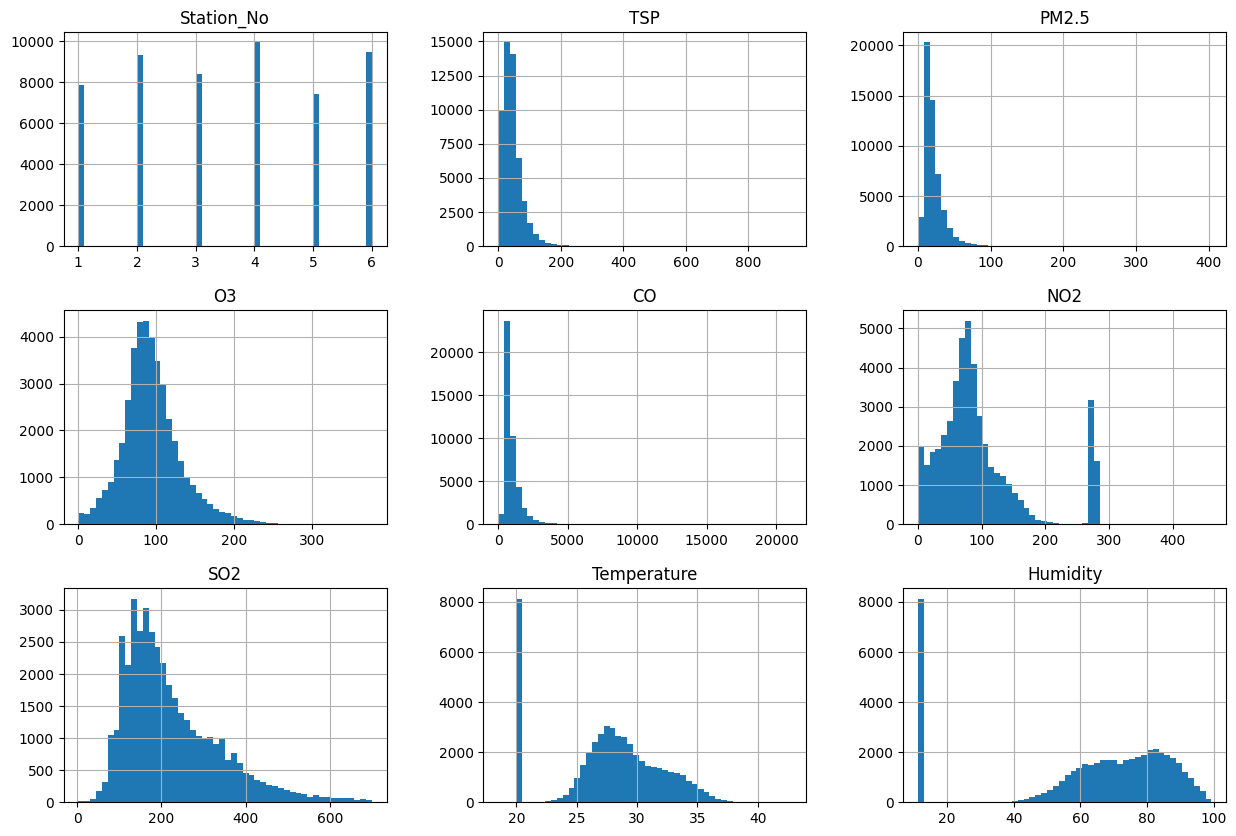

In [ ]:
#trực quan hóa dữ liệu ban đầu
df.hist(bins=50, figsize=(15, 10))
plt.show()

corr_value = df['CO'].corr(df['PM2.5'])


Hệ số tương quan CO vs PM2.5: 0.30


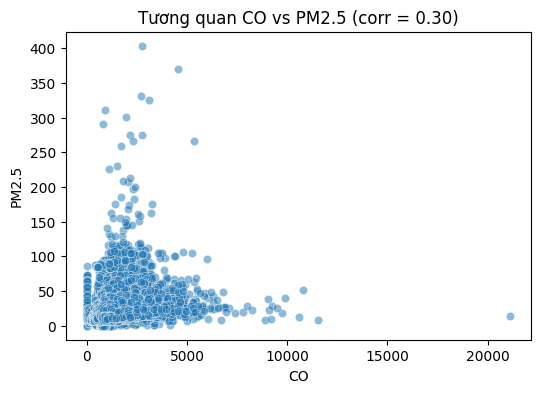

In [ ]:
print(f"Hệ số tương quan CO vs PM2.5: {corr_value:.2f}")
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df['CO'], y=df['PM2.5'], alpha=0.5)
plt.title(f"Tương quan CO vs PM2.5 (corr = {corr_value:.2f})")
plt.xlabel("CO")
plt.ylabel("PM2.5")
plt.show()

Hệ số tương quan O3 vs NO2: 0.30


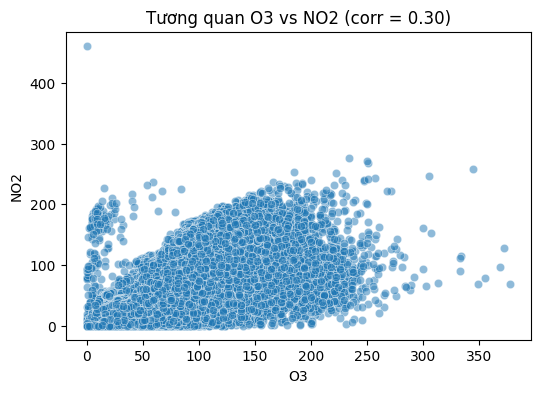

In [ ]:
print(f"Hệ số tương quan O3 vs NO2: {corr_value:.2f}")
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df['O3'], y=df['NO2'], alpha=0.5)
plt.title(f"Tương quan O3 vs NO2 (corr = {corr_value:.2f})")
plt.xlabel("O3")
plt.ylabel("NO2")
plt.show()

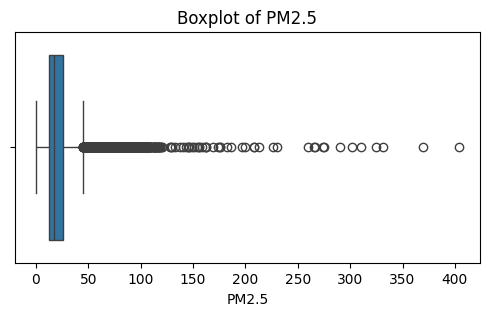

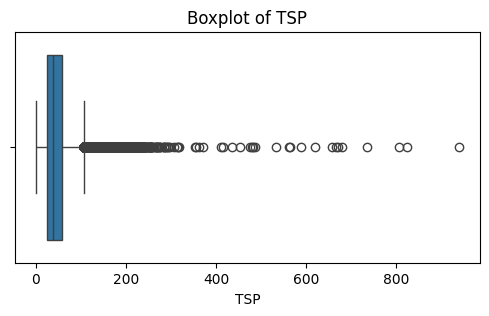

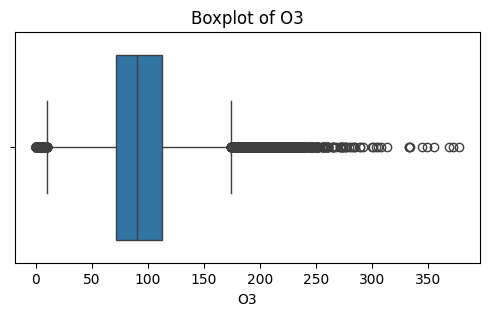

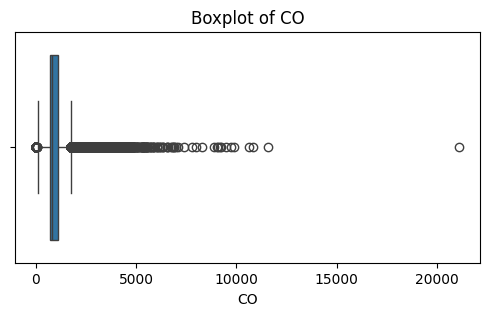

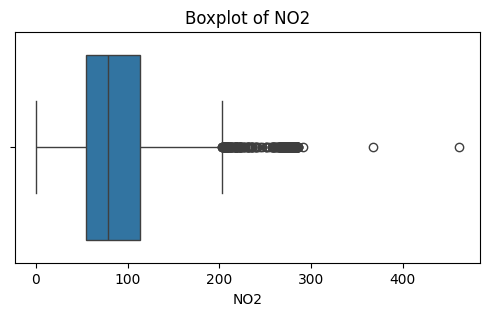

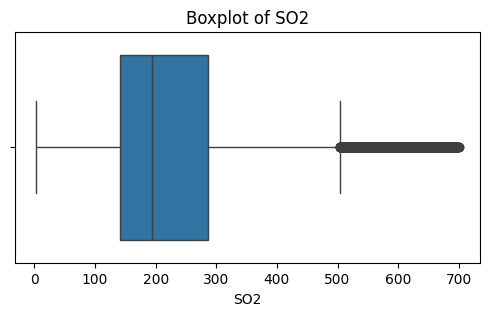

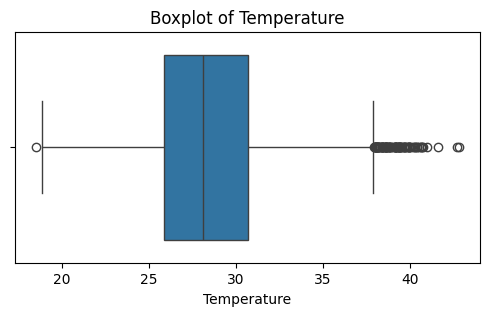

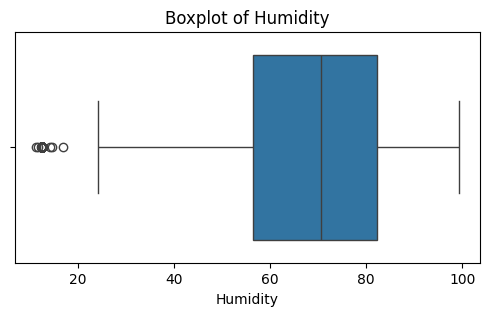

In [ ]:
features = ['PM2.5','TSP', 'O3', 'CO', 'NO2', 'SO2', 'Temperature', 'Humidity']
for col in features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()



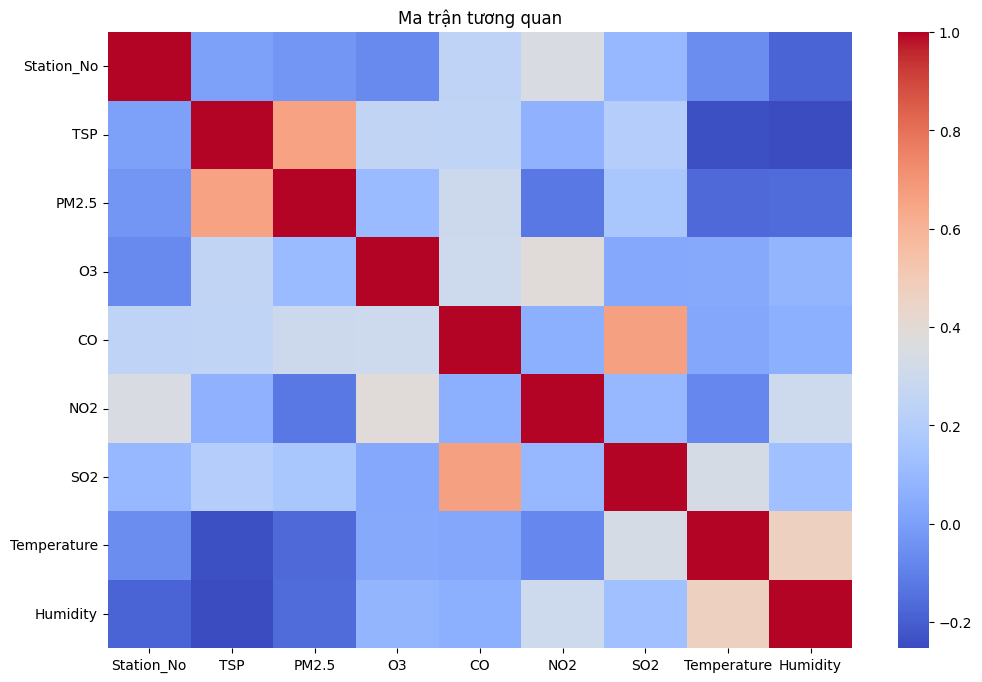

In [ ]:
corr = df.drop('date', axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Ma trận tương quan")
plt.show()

In [ ]:
# Kiểm tra dữ liệu NaN
nan_counts = df.isna().sum()
cols_with_nan = nan_counts[nan_counts > 0]
print("Các cột có NaN:")
print(cols_with_nan)

Các cột có NaN:
TSP               60
O3             10610
CO              9065
NO2             5666
SO2            11006
Temperature     4437
Humidity        4432
dtype: int64


In [ ]:
# kiểm tra xem bao nhiêu % dữ liệu NaN
nan_percent = nan_counts/len(df) * 100
print("Tỷ lệ NaN theo cột (%):")
print(nan_percent[nan_percent > 0].round(2))

Tỷ lệ NaN theo cột (%):
TSP             0.11
O3             20.19
CO             17.25
NO2            10.78
SO2            20.94
Temperature     8.44
Humidity        8.43
dtype: float64


# Tiền xử lý





In [3]:
# ép kiểu cho data chuẩn bị cho bước tách
df['date'] = pd.to_datetime(df['date'])
df.sort_values(['Station_No', 'date'], inplace=True)

/tmp/ipython-input-2192461729.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


In [4]:
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

In [5]:
df['hour'].head()


,hour
0,21
1,22
2,23
3,0
4,1


In [6]:
# NaN < 5% có 1 mẫu TSP -> linear interpolation
df["TSP"] = df["TSP"].interpolate(method='linear')

# NaN 5-20%: CO, NO2, Temperature, Humidity -> KNN imputer
from sklearn.impute import KNNImputer
cols_with_nan = ["CO", "NO2", "Temperature", "Humidity"]
impute = KNNImputer(n_neighbors=4, weights="distance")
df[cols_with_nan] = impute.fit_transform(df[cols_with_nan])

In [7]:
nan_counts = df.isna().sum()
cols_with_nan_pro = nan_counts[nan_counts > 0]
print("Các cột có NaN sau nội suy:")
print(cols_with_nan_pro)

Các cột có NaN sau nội suy:
O3     10610
SO2    11006
dtype: int64


In [8]:
df['SO2'] = df['SO2'].interpolate(method='linear')
df['O3'] = df['O3'].interpolate(method='linear')


In [9]:
nan_counts = df.isna().sum()
cols_with_nan = nan_counts[nan_counts > 0]
print("Các cột có NaN sau nội suy:")
print(cols_with_nan)

Các cột có NaN sau nội suy:
Series([], dtype: int64)


#### trực quan hoá sau xử lý missing value
  - heatmap thể hiện giá trị NaN hay không NaN.

    - Màu sáng → ô dữ liệu bị thiếu.

    - Màu tối → ô dữ liệu có giá trị.

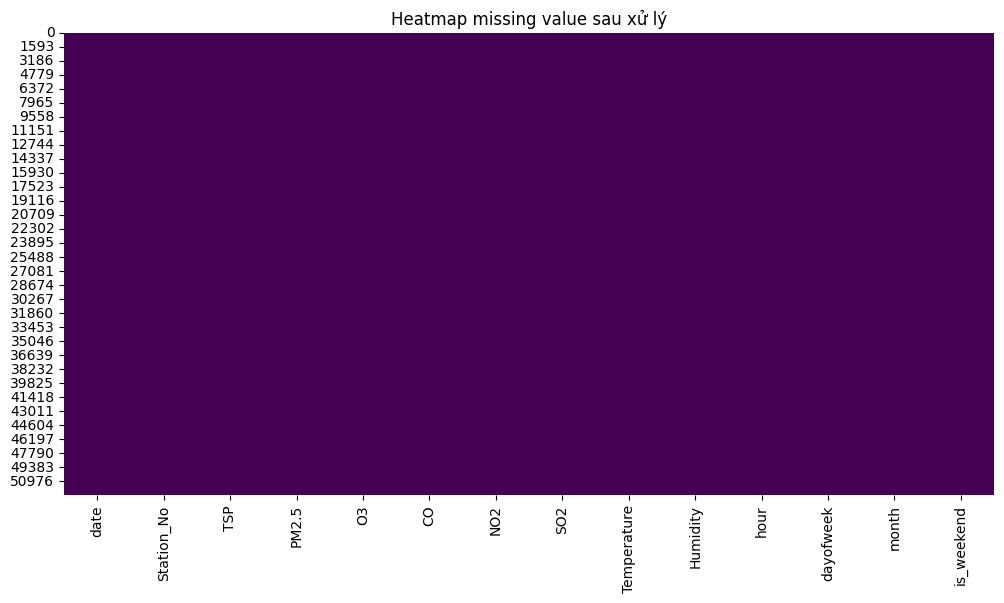

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, cmap="viridis")
plt.title("Heatmap missing value sau xử lý")
plt.show()

In [10]:
save_dir = "/content/drive/MyDrive/Chỉnh lại PM2.5"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "data.csv")

df.to_csv(save_path, index=False)


In [11]:
# df1 = pd.read_csv(save_path)
df1 = pd.read_csv("/content/drive/MyDrive/Chỉnh lại PM2.5/data.csv")
df1.head()

,date,Station_No,TSP,PM2.5,O3,CO,NO2,SO2,Temperature,Humidity,hour,dayofweek,month,is_weekend
0,2021-02-23 21:00:00,1,32.935714,15.604762,55.431381,1330.451429,112.740762,393.000000,28.361905,63.188095,21,1,2,0
1,2021-02-23 22:00:00,1,30.932353,14.594118,58.197176,1200.603529,112.366471,377.588235,28.320588,63.773529,22,1,2,0
2,2021-02-23 23:00:00,1,27.645000,13.436667,55.029433,1177.897000,112.700433,372.476667,28.336667,64.205000,23,1,2,0
3,2021-02-24 00:00:00,1,24.380000,12.365000,54.767700,1267.476000,112.480867,389.070000,28.305000,64.735000,0,2,2,0
4,2021-02-24 01:00:00,1,22.521667,11.636667,53.786200,1322.293000,114.331500,393.000000,28.300000,65.188333,1,2,2,0


#### Ngoại lai (Outliers)

  - Không loại bỏ hẳn (vì ô nhiễm đỉnh có ý nghĩa).

  - Biến đổi bằng log1p hoặc RobustScaler để giảm ảnh hưởng cực trị.

## 2. Biến đổi dữ liệu (Feature Engineering)




#### Lag features (đặc trưng trễ)(PM2.5, CO, O3, TSP, NO2, SO2 ,Temperature, Humidity)
- Lag từng cái
- Rolling (mean + std): cho mô hình biết xu hướng & biến động trong khoảng thời gian dài hơn (12h, 24h, 72h…).

In [12]:
df1['hour_sin'] = np.sin(2 * np.pi * df1['hour']/24)
df1['hour_cos'] = np.cos(2 * np.pi * df1['hour']/24)

In [13]:
lags = [1,24]  # t-1, t-24h
for col in ['PM2.5', 'CO']:
    for lag in lags:
        df1[f'{col}_lag{lag}'] = df1.groupby('Station_No')[col].shift(lag)

- xử lý lại NaN

In [14]:
nan_counts = df1.isna().sum()
cols_with_nan = nan_counts[nan_counts > 0]
print("Các cột có NaN sau xử lý giá trị ngoại lai:")
print(cols_with_nan)

Các cột có NaN sau xử lý giá trị ngoại lai:
PM2.5_lag1       6
PM2.5_lag24    144
CO_lag1          6
CO_lag24       144
dtype: int64


In [15]:
# kiểm tra xem bao nhiêu % dữ liệu NaN
nan_percent = nan_counts/len(df1) * 100
print("Tỷ lệ NaN theo cột (%):")
print(nan_percent[nan_percent > 0].round(2))

Tỷ lệ NaN theo cột (%):
PM2.5_lag1     0.01
PM2.5_lag24    0.27
CO_lag1        0.01
CO_lag24       0.27
dtype: float64


In [16]:
# < 10% -> dùng nội suy linear
# PM2.5_lag1     0.01
# PM2.5_lag24    0.27
# CO_lag1        0.01
# CO_lag24       0.27
cols_to_interpolate = ["PM2.5_lag1", "PM2.5_lag24", "CO_lag1", "CO_lag24"]

for col in cols_to_interpolate:
    if col in df1.columns:
        df1[col] = df1[col].interpolate(method='linear', limit_direction='both')
    else:
        print(f"Warning: {col} not found in df1 columns.")


In [17]:
nan_counts = df1.isna().sum()
cols_with_nan = nan_counts[nan_counts > 0]
print("Các cột có NaN sau nội suy:")
print(cols_with_nan)

Các cột có NaN sau nội suy:
Series([], dtype: int64)


In [18]:
df1.columns

Index(['date', 'Station_No', 'TSP', 'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
       'Temperature', 'Humidity', 'hour', 'dayofweek', 'month', 'is_weekend',
       'hour_sin', 'hour_cos', 'PM2.5_lag1', 'PM2.5_lag24', 'CO_lag1',
       'CO_lag24'],
      dtype='object')

## 3. Chuẩn hóa dữ liệu (Scaling)

- Input features:

  - Dùng RobustScaler (ổn định với outliers) hoặc QuantileTransformer (làm phân phối ~Gaussian).






In [19]:
target_column = 'PM2.5'

feature_columns = [
    'PM2.5',
    'TSP', 'CO', 'O3', 'NO2', 'SO2',
    'Temperature', 'Humidity',
    'hour_sin', 'hour_cos',
    'PM2.5_lag1', 'PM2.5_lag24',
    'CO_lag1', 'CO_lag24',
    'Station_No'
]

In [20]:
feature_columns = [c for c in feature_columns if c in df1.columns]
print("Using features:", feature_columns)

Using features: ['PM2.5', 'TSP', 'CO', 'O3', 'NO2', 'SO2', 'Temperature', 'Humidity', 'hour_sin', 'hour_cos', 'PM2.5_lag1', 'PM2.5_lag24', 'CO_lag1', 'CO_lag24', 'Station_No']


In [21]:
X = df1[feature_columns].values


In [22]:
log_transform_target = True

if log_transform_target:
    y = np.log1p(df1[target_column].values)
else:
    y = df1[target_column].values


## 4. Tạo chuỗi (Sequence Preparation)

- Chia dữ liệu thành lookback sequences:

  - lookback = 72 (3 ngày) hoặc 168 (1 tuần) để bắt chu kỳ ngắn + dài.

- Input: multivariate (PM2.5, O3, CO, NO2, SO2, TSP, Temp, Humidity, time features, station).

- Output: PM2.5(t+1).



In [23]:
def create_sequences(X, y, lookback=72):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    return np.array(X_seq), np.array(y_seq)
#28,48
lookback = 48
y = np.log1p(df1['PM2.5'].values)
X_seq, y_seq = create_sequences(X, y, lookback)

print(f"Sequences shape: X={X_seq.shape}, y={y_seq.shape}")

Sequences shape: X=(52500, 48, 15), y=(52500,)


In [24]:
nan_counts = df1.isna().sum()
cols_with_nan = nan_counts[nan_counts > 0]
print("Các cột có NaN sau xử lý NaN:")
print(cols_with_nan)

Các cột có NaN sau xử lý NaN:
Series([], dtype: int64)


## 5. Chia dữ liệu (Split Data)

- Giữ nguyên thứ tự thời gian (không shuffle).

- Train ~80%, Validation ~10%, Test ~10%.

In [25]:
train_size = int(len(X_seq) * 0.8)
val_size = int(len(X_seq) * 0.1)

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

print("Data split:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Data split:
X_train: (42000, 48, 15) y_train: (42000,)
X_val: (5250, 48, 15) y_val: (5250,)
X_test: (5250, 48, 15) y_test: (5250,)


In [26]:
n_train, t, f = X_train.shape
X_train_2d = X_train.reshape(n_train * t, f)

scaler_x = RobustScaler()
X_train_scaled_2d = scaler_x.fit_transform(X_train_2d)

X_train_scaled = X_train_scaled_2d.reshape(n_train, t, f)


In [27]:

n_val = X_val.shape[0]
X_val_2d = X_val.reshape(n_val * t, f)

X_val_scaled_2d = scaler_x.transform(X_val_2d)
X_val_scaled = X_val_scaled_2d.reshape(n_val, t, f)


In [28]:
n_test = X_test.shape[0]
X_test_2d = X_test.reshape(n_test * t, f)

X_test_scaled_2d = scaler_x.transform(X_test_2d)
X_test_scaled = X_test_scaled_2d.reshape(n_test, t, f)


In [29]:
# y_train / y_val / y_test stay in log space (no scaling)
print("Scaling done. Shapes:", X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

Scaling done. Shapes: (42000, 48, 15) (5250, 48, 15) (5250, 48, 15)


# Train

## 6. Training considerations

- Dùng EarlyStopping (patience 10–15) để tránh overfit.

- Regularization: Dropout 0.3–0.5, L2.



### Model

In [30]:
!pip install tensorflow

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, GRU, SimpleRNN, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [32]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

In [33]:
class LuongAttention(Layer):
    def __init__(self, **kwargs):
        super(LuongAttention, self).__init__(**kwargs)

    def call(self, query, values):
        query = tf.expand_dims(query, 1)   # shape (B,1,H)
        scores = tf.matmul(query, values, transpose_b=True)
        weights = tf.nn.softmax(scores, axis=-1)
        context = tf.matmul(weights, values)
        return tf.squeeze(context, axis=1)


def build_bilstm_optimal(input_shape):
    inp = Input(shape=input_shape)

    # ---- CNN không pooling ----
    x = Conv1D(64, 3, padding='same', activation='relu')(inp)
    x = Conv1D(64, 3, padding='same', activation='relu')(x)

    # ---- Bi-LSTM ----
    x = Bidirectional(LSTM(128, return_sequences=True,
                           dropout=0.25, recurrent_dropout=0.1))(x)

    x = Bidirectional(LSTM(64, return_sequences=True,
                           dropout=0.25, recurrent_dropout=0.1))(x)

    # ---- Attention (fixed) ----
    query = Lambda(lambda t: t[:, -1, :])(x)
    context = LuongAttention()(query, x)

    # ---- Dense head ----
    d = Dense(128, activation='relu')(context)
    d = Dropout(0.2)(d)
    d = Dense(64, activation='relu')(d)

    out = Dense(1)(d)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(1e-3),
        loss=tf.keras.losses.Huber(delta=1.0),
        metrics=['mae']
    )
    return model


In [ ]:
# 1. Build model
model_bilstm_optimal = build_bilstm_optimal(input_shape=X_train_scaled.shape[1:])

# 2. Callbacks
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    min_lr=1e-5
)

early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

callbacks = [lr_schedule, early]

# 3. Train
history_bilstm = model_bilstm_optimal.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 373s 542ms/step - loss: 0.1797 - mae: 0.4334 - val_loss: 0.0933 - val_mae: 0.3281 - learning_rate: 0.0010
Epoch 2/10
416/657 ━━━━━━━━━━━━━━━━━━━━ 2:10 541ms/step - loss: 0.0380 - mae: 0.2023

In [ ]:
y_pred = model_bilstm_optimal.predict(X_test_scaled).reshape(-1)
y_pred = np.expm1(y_pred)
y_true = np.expm1(y_test.reshape(-1))

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("---- Đánh giá Bi-LSTM (optimal) ----")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE : {mse:.4f}")
print(f"R²  : {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
---- Đánh giá Bi-LSTM (optimal) ----
MAE : 6.9693
RMSE: 10.6485
MSE : 113.3909
R²  : 0.1863
MAPE: 28.56%


In [ ]:
callbacks_common = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

In [ ]:
EPOCHS = 25
BATCH_SIZE = 64
BASE_LR = 1e-3
WEIGHT_DECAY = 1e-4
CLIPNORM = 1.0

In [ ]:
def make_optimizer(lr=BASE_LR, clipnorm=CLIPNORM):
    return tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=clipnorm)

In [ ]:
def build_bilstm_opt(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True,
                           kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
                      input_shape=input_shape),
        Dropout(0.25),
        Bidirectional(LSTM(64, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
        BatchNormalization(),
        Dropout(0.15),
        Dense(1)
    ])
    model.compile(optimizer=make_optimizer(), loss='mse', metrics=['mae'])
    return model


In [ ]:
# input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
# model = build_bilstm(input_shape)
# model.summary()

In [ ]:

# input_shape = (X_train.shape[1], X_train.shape[2])
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])

In [ ]:
# history = model.fit(
#     X_train_scaled, y_train,
#     validation_data=(X_val_scaled, y_val),
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     callbacks=callbacks,
#     verbose=1
# )
# model_bilstm.save(os.path.join("/content/drive/MyDrive/PM2.5(t+1)/Model_train", "model_bilstm1.keras"))

model_bilstm_opt = build_bilstm_opt(input_shape)
model_bilstm_opt.summary()
# use a model checkpoint for safety
ckpt_bilstm = ModelCheckpoint("best_bilstm_opt.keras", monitor='val_loss', save_best_only=True, verbose=1)
hist_bilstm = model_bilstm_opt.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    callbacks=callbacks_common + [ckpt_bilstm],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 48, 256)        │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,385 (1.22 MB)

 Trainable params: 320,257 (1.22 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/25
654/657 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.8285 - mae: 1.5397
Epoch 1: val_loss improved from inf to 0.22510, saving model to best_bilstm_opt.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 3.8153 - mae: 1.5357 - val_loss: 0.2251 - val_mae: 0.2654 - learning_rate: 0.0010
Epoch 2/25
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3061 - mae: 0.3781
Epoch 2: val_loss improved from 0.22510 to 0.16131, saving model to best_bilstm_opt.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.3060 - mae: 0.3780 - val_loss: 0.1613 - val_mae: 0.1921 - learning_rate: 0.0010
Epoch 3/25
654/657 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1907 - mae: 0.2920
Epoch 3: val_loss improved from 0.16131 to 0.13574, saving model to best_bilstm_opt.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.1907 - mae: 0.2919 - val_loss: 0.1357 - val_mae: 0.1807 - learning_rate: 0.0010
Epoch 4/25
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1432 - mae: 0.2564
Epoch 4

In [ ]:
def plot_loss_mae(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'{title} - MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



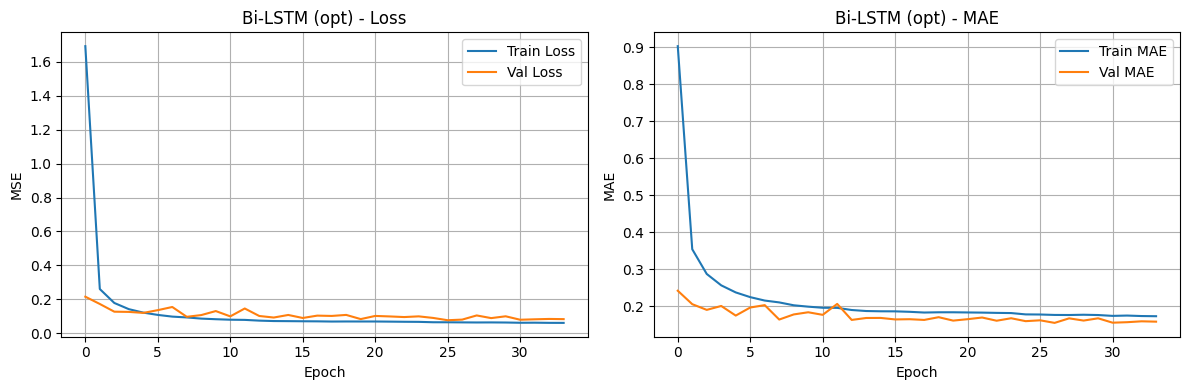

In [ ]:
plot_loss_mae(hist_bilstm, "Bi-LSTM (opt)")

### RNN, GRU

In [ ]:

def build_rnn_opt(input_shape):
    model = Sequential([
        SimpleRNN(128, return_sequences=True, kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
                  input_shape=input_shape),
        Dropout(0.25),
        SimpleRNN(64, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
        BatchNormalization(),
        Dropout(0.15),
        Dense(1)
    ])
    model.compile(optimizer=make_optimizer(), loss='mse', metrics=['mae'])
    return model


def build_gru_opt(input_shape):
    model = Sequential([
        GRU(128, return_sequences=True, kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            input_shape=input_shape),
        Dropout(0.25),
        GRU(64, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
        BatchNormalization(),
        Dropout(0.15),
        Dense(1)
    ])
    model.compile(optimizer=make_optimizer(), loss='mse', metrics=['mae'])
    return model


In [ ]:

model_rnn_opt = build_rnn_opt(input_shape)
model_rnn_opt.summary()
ckpt_rnn = ModelCheckpoint("best_rnn_opt.keras", monitor='val_loss', save_best_only=True, verbose=1)
hist_rnn = model_rnn_opt.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    callbacks=callbacks_common + [ckpt_rnn],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 48, 128)        │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,265 (137.75 KB)

 Trainable params: 35,137 (137.25 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.9896 - mae: 1.5754
Epoch 1: val_loss improved from inf to 0.27893, saving model to best_rnn_opt.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 3.9861 - mae: 1.5744 - val_loss: 0.2789 - val_mae: 0.3215 - learning_rate: 0.0010
Epoch 2/25
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2936 - mae: 0.4080
Epoch 2: val_loss improved from 0.27893 to 0.21735, saving model to best_rnn_opt.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.2935 - mae: 0.4079 - val_loss: 0.2174 - val_mae: 0.2306 - learning_rate: 0.0010
Epoch 3/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1936 - mae: 0.3243
Epoch 3: val_loss did not improve from 0.21735
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1936 - mae: 0.3243 - val_loss: 0.2197 - val_mae: 0.2376 - learning_rate: 0.0010
Epoch 4/25
654/657 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1527 - mae: 0.2818
Epoch 4: val_loss improved from 0.21735 to 0.18964, saving 

In [ ]:


model_gru_opt = build_gru_opt(input_shape)
model_gru_opt.summary()
ckpt_gru = ModelCheckpoint("best_gru_opt.keras", monitor='val_loss', save_best_only=True, verbose=1)
hist_gru = model_gru_opt.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    callbacks=callbacks_common + [ckpt_gru],
    verbose=1
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 48, 128)        │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,409 (380.50 KB)

 Trainable params: 97,281 (380.00 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/25
653/657 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8557 - mae: 1.5548
Epoch 1: val_loss improved from inf to 0.15989, saving model to best_gru_opt.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 3.8389 - mae: 1.5498 - val_loss: 0.1599 - val_mae: 0.2161 - learning_rate: 0.0010
Epoch 2/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2793 - mae: 0.3864
Epoch 2: val_loss improved from 0.15989 to 0.14494, saving model to best_gru_opt.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.2792 - mae: 0.3864 - val_loss: 0.1449 - val_mae: 0.2009 - learning_rate: 0.0010
Epoch 3/25
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1713 - mae: 0.2996
Epoch 3: val_loss improved from 0.14494 to 0.11690, saving model to best_gru_opt.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1712 - mae: 0.2995 - val_loss: 0.1169 - val_mae: 0.1800 - learning_rate: 0.0010
Epoch 4/25
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1360 - mae: 0.2641
Epoch 4: val_loss 

# 7. Trực quan hóa và đánh giá mô hình

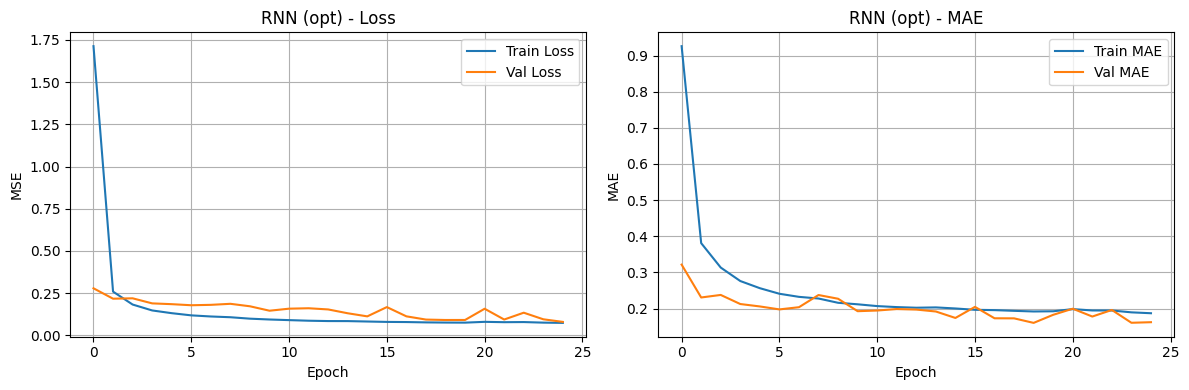

In [ ]:

plot_loss_mae(hist_rnn, "RNN")


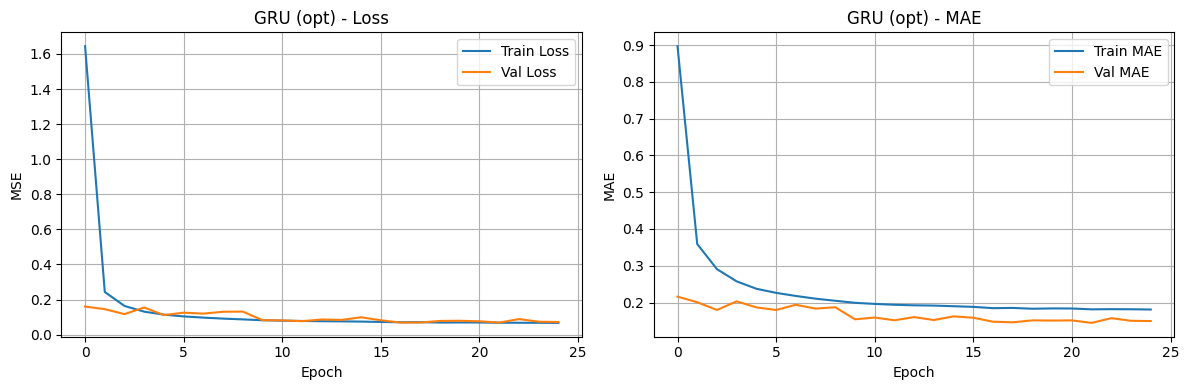

In [ ]:

plot_loss_mae(hist_gru, "GRU")

In [ ]:

def evaluate_model(model, X_test_scaled, y_test, title="Model"):
    y_pred_log = model.predict(X_test_scaled, verbose=0)
    y_pred = np.expm1(y_pred_log.reshape(-1))
    y_true = np.expm1(y_test.reshape(-1))

    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred)) & (~np.isinf(y_true)) & (~np.isinf(y_pred))
    y_true = y_true[mask]; y_pred = y_pred[mask]

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    print(f"\n---- Đánh giá {title} ----")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"R²  : {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    return y_true, y_pred, dict(mae=mae, rmse=rmse, mse=mse, r2=r2, mape=mape)

In [ ]:
metrics_results = {}
y_true_bi, y_pred_bi, metrics_results['Bi-LSTM'] = evaluate_model(model_bilstm_opt, X_test_scaled, y_test, "Bi-LSTM")
y_true_gru, y_pred_gru, metrics_results['GRU']     = evaluate_model(model_gru_opt, X_test_scaled, y_test, "GRU")
y_true_rnn, y_pred_rnn, metrics_results['RNN']     = evaluate_model(model_rnn_opt, X_test_scaled, y_test, "RNN")


---- Đánh giá Bi-LSTM ----
MAE : 3.6220
RMSE: 7.9394
MSE : 63.0344
R²  : 0.5476
MAPE: 14.44%

---- Đánh giá GRU ----
MAE : 3.0616
RMSE: 7.3553
MSE : 54.1003
R²  : 0.6118
MAPE: 13.39%

---- Đánh giá RNN ----
MAE : 3.1236
RMSE: 7.4556
MSE : 55.5866
R²  : 0.6011
MAPE: 13.62%


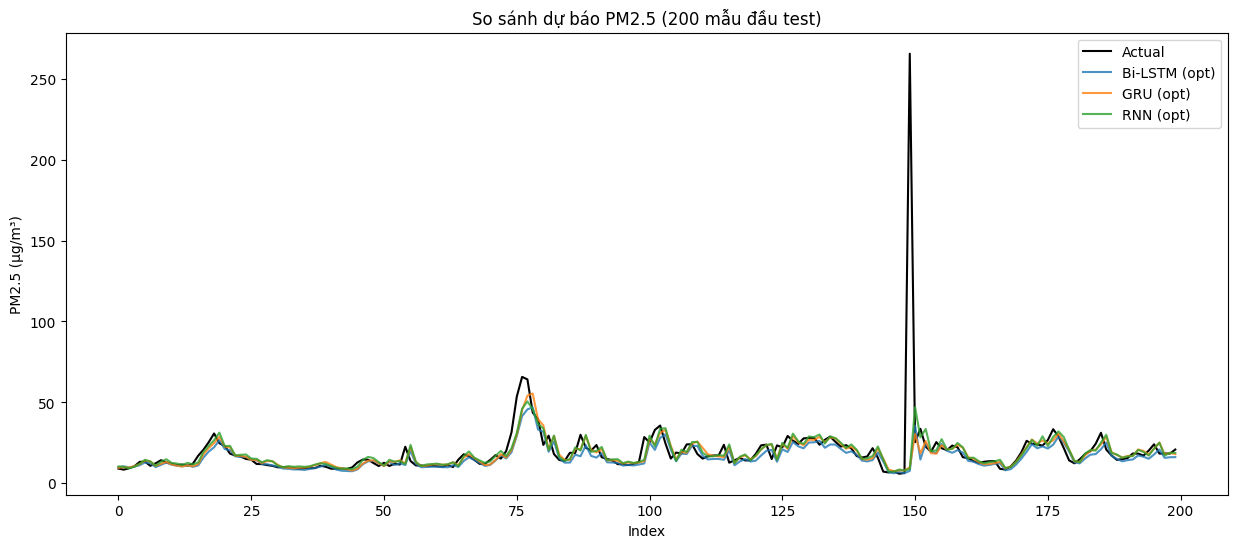

In [ ]:
# plt.figure(figsize=(15,6))
# plt.plot(y_true_rnn[:200], label='Thực tế', color='black')
# plt.plot(y_pred_rnn[:200], label='RNN', alpha=0.7)
# plt.plot(y_pred_gru[:200], label='GRU', alpha=0.7)
# plt.plot(y_pred[:200], label='Bi-LSTM', alpha=0.7)
# plt.title("So sánh dự báo PM2.5 (200 mẫu đầu test)")
# plt.xlabel("Thời gian")
# plt.ylabel("PM2.5 (µg/m³)")
# plt.legend()
# plt.show()
plt.figure(figsize=(15,6))
plt.plot(y_true_bi[:200], label='Actual', color='k')
plt.plot(y_pred_bi[:200], label='Bi-LSTM (opt)', alpha=0.8)
plt.plot(y_pred_gru[:200], label='GRU (opt)', alpha=0.8)
plt.plot(y_pred_rnn[:200], label='RNN (opt)', alpha=0.8)
plt.title("So sánh dự báo PM2.5 (200 mẫu đầu test)")
plt.xlabel("Index"); plt.ylabel("PM2.5 (µg/m³)")
plt.legend(); plt.show()